In [1]:
import numpy as np
import utils

### Given
- A dataset containing 3 different classes of images
- A CNN with the following architecture and cross entropy loss function


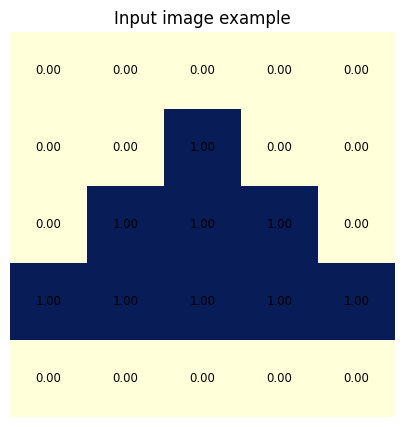

In [4]:
# Input: random 5x5 integer matrix
# 3 classes: Triangle (0),  Line (1), Square (2)
# The shape of the input matrix is (1, 5, 5) and not (5, 5) because we can later generalize to images with more than one channel
input_triangle = np.array([[
    [0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0]
]])
input_line = np.array([[
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0]
]])
input_square = np.array([[
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0]
]])

TRIANGLE = np.array([1., 0., 0.])
LINE = np.array([0., 1., 0.])
SQUARE = np.array([0., 0., 1.])
images = np.array([input_triangle, input_line, input_square])
labels = np.array([TRIANGLE, LINE, SQUARE]).reshape(3, 3, 1)

(x_train, y_train) = (np.array(images), np.array(labels))
(x_test, y_test) = (np.array(images), np.array(labels))

utils.display_images([(images[0, 0], "Input image example")], figsize=(5, 5))

In [5]:
# https://medium.com/analytics-vidhya/2d-convolution-using-python-numpy-43442ff5f381
# https://github.com/macbuse/macbuse.github.io/blob/master/PROG/convolve.py
def convolve2D(image: np.ndarray, kernel: np.ndarray, mode = "valid", correlation = False):
    # Cross correlation or Convolution depends on the orientation of the kernel
    kernel = kernel if correlation else np.flipud(np.fliplr(kernel))

    # Gather shapes of kernel + image + padding
    x_kernel_size, y_kernel_size = kernel.shape
    x_image_size, y_image_size = image.shape[0:2]

    if mode == "valid":
        # Ouput matrix size of a full convolution
        x_output = int(x_image_size - x_kernel_size + 1)
        y_output = int(y_image_size - y_kernel_size + 1)
        output = np.zeros((x_output, y_output))

        for y in range(0, y_image_size - y_kernel_size + 1):
            for x in range(0, x_image_size - x_kernel_size + 1):
                output[x, y] = (kernel * image[x: x + x_kernel_size, y: y + y_kernel_size]).sum()
    
    elif mode == "full":
        # Output matrix size of a valid convolution
        x_output = int((x_image_size + x_kernel_size - 1))
        y_output = int((y_image_size + y_kernel_size - 1))
        image_padded = np.pad(image, x_kernel_size - 1, mode='constant', constant_values=(0))
        output = np.zeros((x_output, y_output))

        for x in range(0, output.shape[0]):
            for y in range(0, output.shape[1]):
                output[x, y] = (kernel * image_padded[x: x + x_kernel_size, y: y + y_kernel_size]).sum()
        
    return output

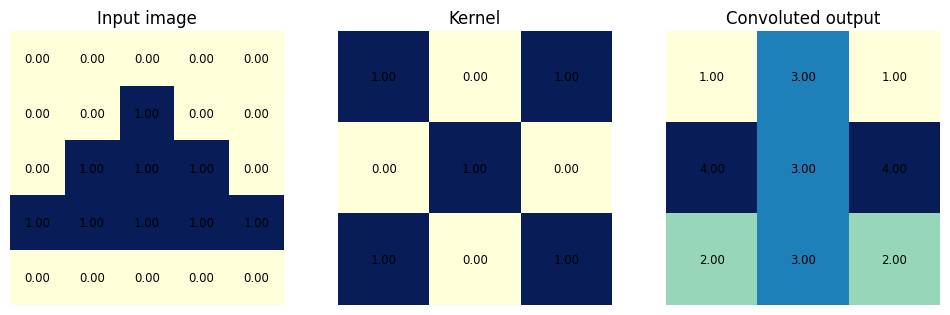

In [7]:
# 1x1 filter
kernel = np.array([[1]])

# 2x2 filter
kernel = np.array([[1, 0], [1, 0]])

# 3x3 filter
kernel = np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]])

convoluted_output = convolve2D(images[0, 0], kernel, mode = 'valid', correlation = True)
utils.display_images([(images[0, 0], "Input image"), (kernel, "Kernel"), (convoluted_output, "Convoluted output")])

In [8]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
    
    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update params and return input gradient
        pass

In [9]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)
    
    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias
    
    def backward(self, output_gradient, learning_rate):
        # Update params and return input gradient
        weights_gradient = np.dot(output_gradient, self.input.T)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return np.dot(self.weights.T, output_gradient)

In [10]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime
    
    def forward(self, input):
        self.input = input
        return self.activation(self.input)
    
    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [11]:
class Tanh(Activation):
    def __init__(self):
        tanh = lambda x: np.tanh(x)
        tanh_prime = lambda x: 1 - np.tanh(x)**2
        super().__init__(tanh, tanh_prime)

In [12]:
class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        tmp = np.tile(self.output, n)
        return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)

In [13]:
class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth # number of kernels
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size) # multiple 3D kernels
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)
    
    
    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += convolve2D(self.input[j], self.kernels[i, j])
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = convolve2D(self.input[j], output_gradient[i], "valid", correlation = True)
                input_gradient[j] += convolve2D(output_gradient[i], self.kernels[i, j], "full")
        
        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient



In [14]:
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
    
    def forward(self, input):
        return np.reshape(input, self.output_shape)
    
    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

In [15]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))
        
        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)
            
        super().__init__(sigmoid, sigmoid_prime)

### Loss functions
There are a multitude of loss functions, each for its own purpose. I'll later provide 3 examples, 2 approaches to solve binary classification - one with only a FCNN, another with a CNN with binary classification. Last, a CNN with multiclass classification. Each of the different examples have a fitting loss function.

Binary classification: MSE or Binary cross entropy
Multiclass classification: Cross entropy



In [16]:
def binary_cross_entropy(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

def cross_entropy(y_true, y_pred):
    # Make sure not to take log(0) by adding a small value to y_pred
    return -np.sum(y_true * np.log(y_pred + 10**-100))

def cross_entropy_prime(y_true, y_pred):
    # Make sure not to divide by 0 by adding a small value to y_pred
    return - y_true / (y_pred + 10**-100)

def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

### XOR-problem using a FCNN
Example of how we can use the network to train a simple, FCNN which solves the XOR-problem

In [30]:
X = np.reshape([[0,0], [0,1], [1,0], [1,1]], (4, 2, 1))
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

In [31]:
network = [
    Dense(2, 3),
    Tanh(),
    Dense(3, 1),
    Tanh()
]

In [32]:
epochs = 100
learning_rate = 0.1

In [33]:
for epoch in range(epochs):
    error = 0
    for x, y in zip(X, Y):
        # Forward pass
        output = x
        for layer in network:
            output = layer.forward(output)
        
        # Calculate error
        error += mse(y, output)

        # Backward pass
        grad = mse_prime(y, output)
        
        for layer in reversed(network):
            grad = layer.backward(grad, learning_rate)
        
    error /= len(X)
    print(f"Epoch {epoch}, error: {error}")

Epoch 0, error: 0.5238750026174922
Epoch 1, error: 0.265062528735461
Epoch 2, error: 0.24123869837818218
Epoch 3, error: 0.23494917977541757
Epoch 4, error: 0.23132497205695685
Epoch 5, error: 0.22863092577436117
Epoch 6, error: 0.22646830510296045
Epoch 7, error: 0.2246419041405661
Epoch 8, error: 0.2230212082102932
Epoch 9, error: 0.22152064907071603
Epoch 10, error: 0.22008983786472036
Epoch 11, error: 0.2187032025396819
Epoch 12, error: 0.21735068003277486
Epoch 13, error: 0.2160307393111721
Epoch 14, error: 0.2147457834559112
Epoch 15, error: 0.21349942171393244
Epoch 16, error: 0.21229502184550275
Epoch 17, error: 0.21113506086412362
Epoch 18, error: 0.21002093464462532
Epoch 19, error: 0.2089530072689041
Epoch 20, error: 0.20793076779951314
Epoch 21, error: 0.20695301967216628
Epoch 22, error: 0.20601806381040627
Epoch 23, error: 0.20512385786921183
Epoch 24, error: 0.20426814595463277
Epoch 25, error: 0.203448559363482
Epoch 26, error: 0.20266269171203974
Epoch 27, error: 0.201

# Multiclass Classification Problem

In [24]:
LEARNING_RATE = 0.01
MOMENTUM = 0.9
EPOCHS = 300
VISUALIZE_INTERVAL = 20

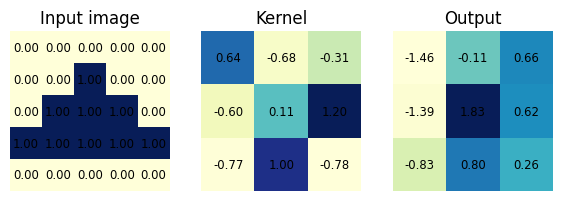

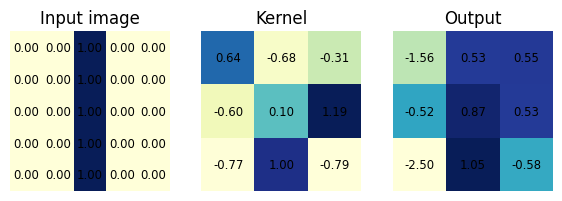

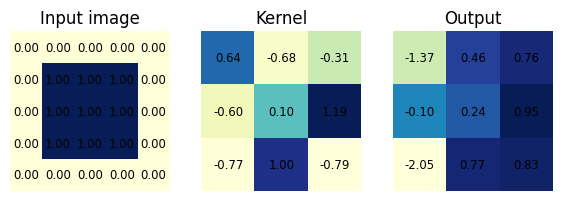

Epoch 0, error: 3.4856737681283314


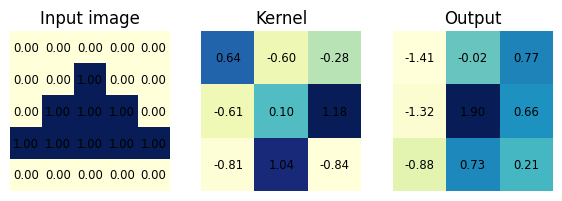

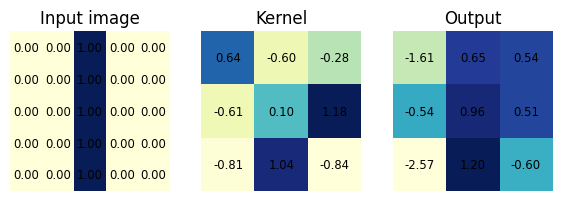

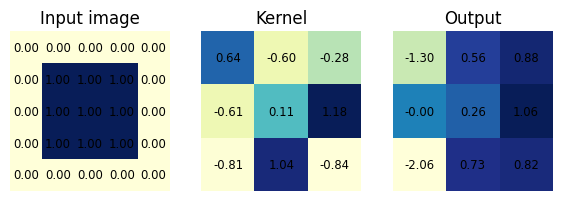

Epoch 20, error: 0.5382972670674327


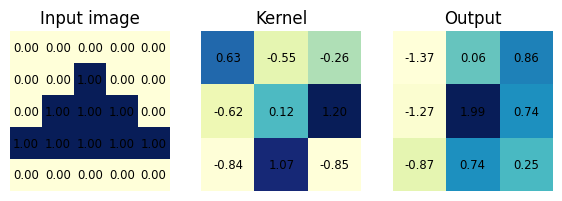

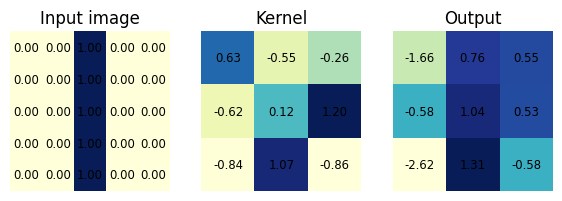

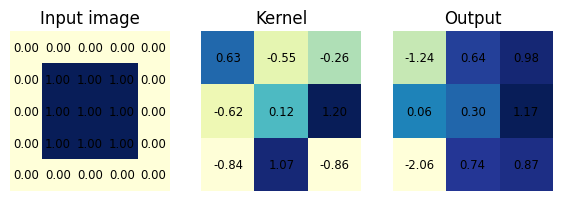

Epoch 40, error: 0.30305429828618186


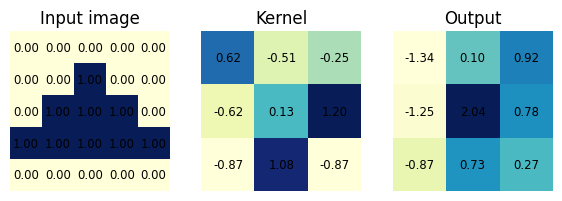

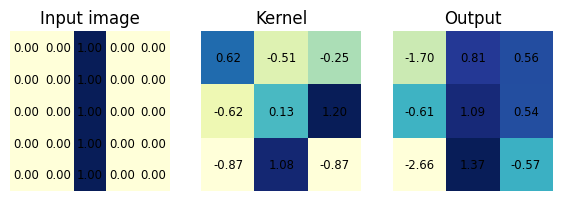

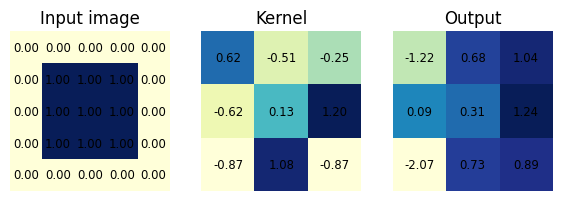

Epoch 60, error: 0.2062180526429465


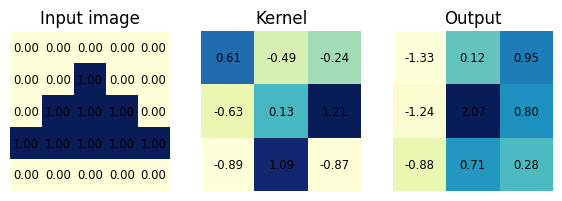

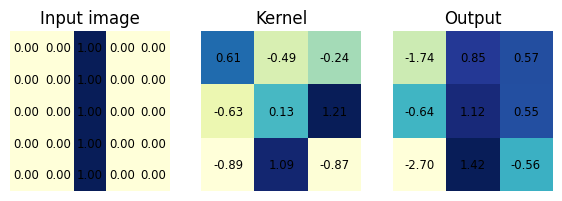

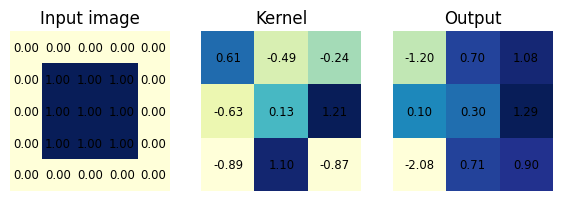

Epoch 80, error: 0.15551315669420485


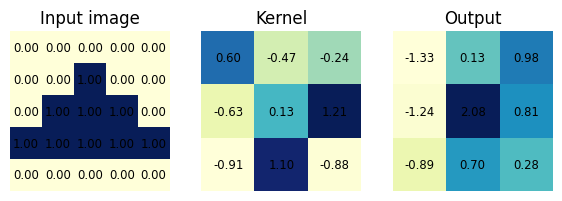

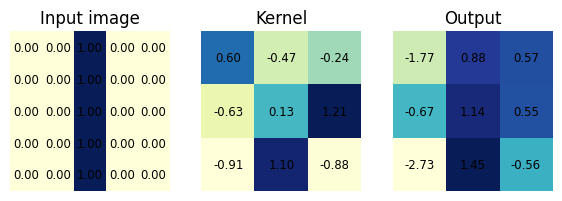

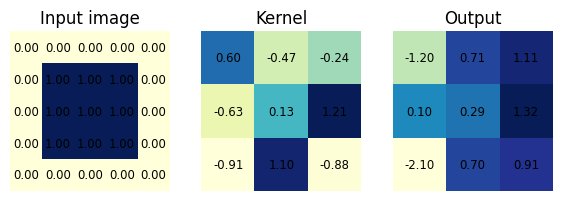

Epoch 100, error: 0.1247367259913899


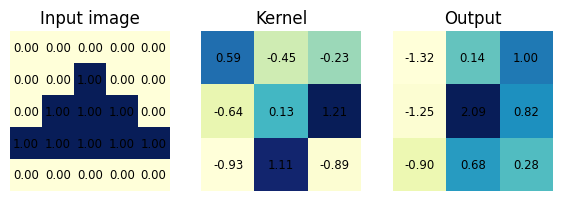

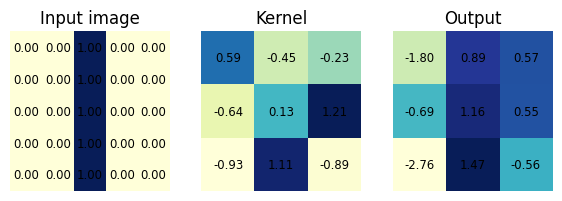

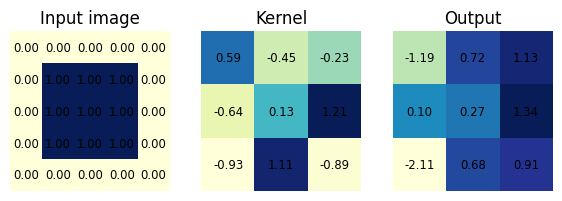

Epoch 120, error: 0.1041798255349937


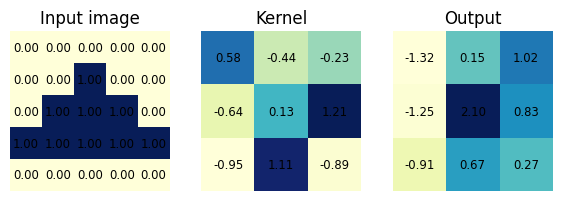

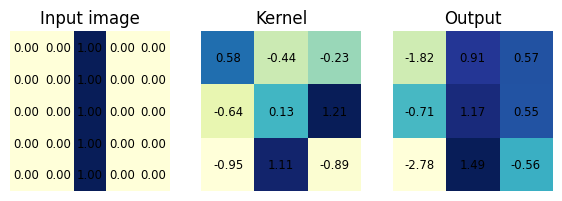

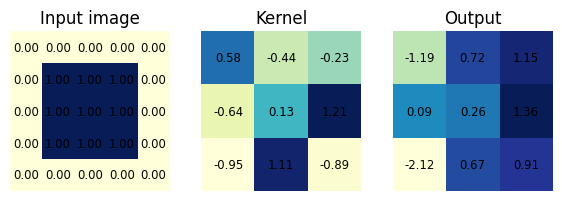

Epoch 140, error: 0.08950801363160803


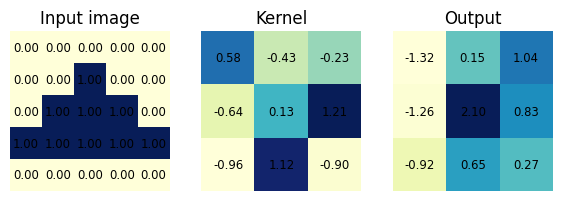

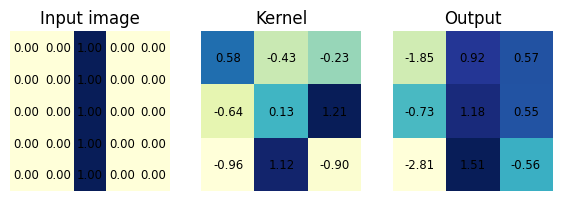

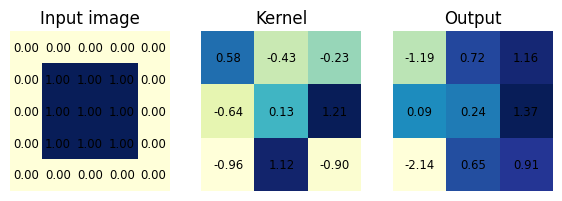

Epoch 160, error: 0.0785170842744138


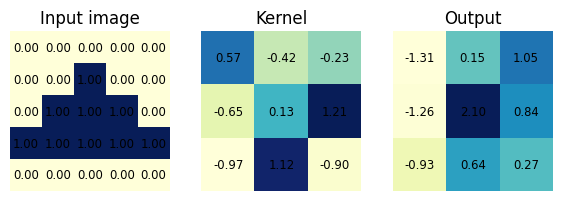

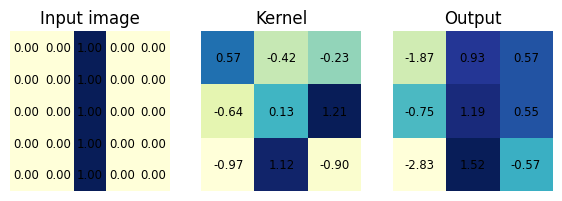

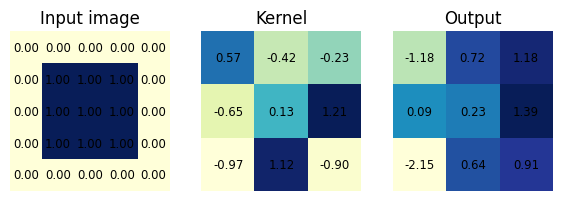

Epoch 180, error: 0.0699749750959574


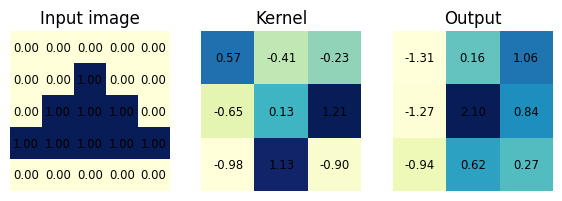

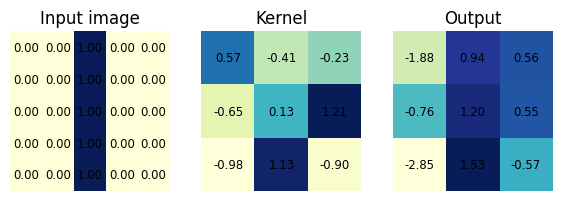

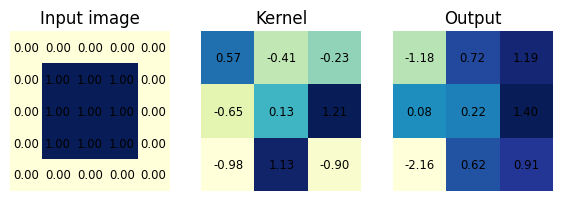

Epoch 200, error: 0.0631419113912246


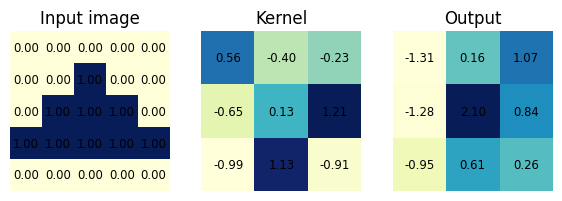

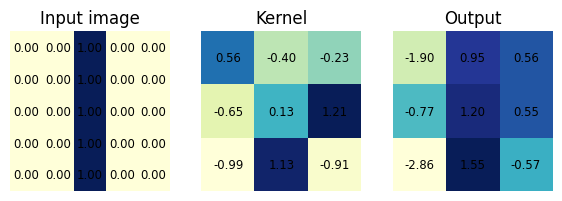

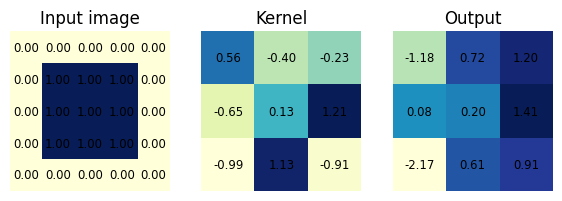

Epoch 220, error: 0.057548057986848415


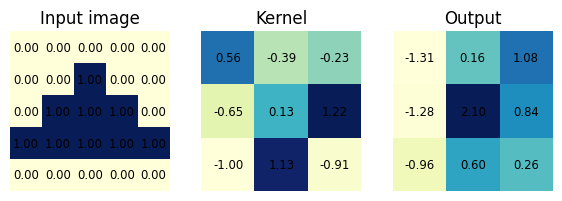

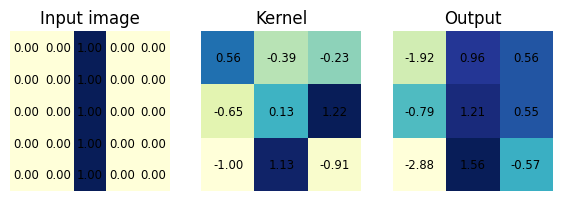

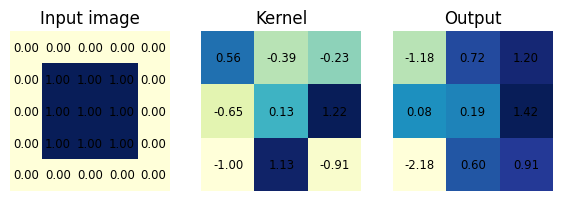

Epoch 240, error: 0.05288120179480362


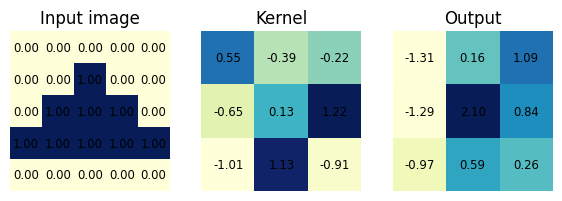

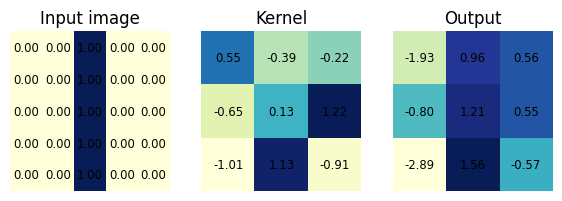

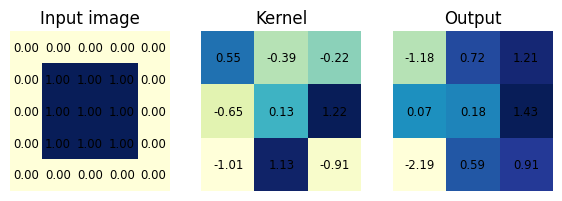

Epoch 260, error: 0.04892598509942644


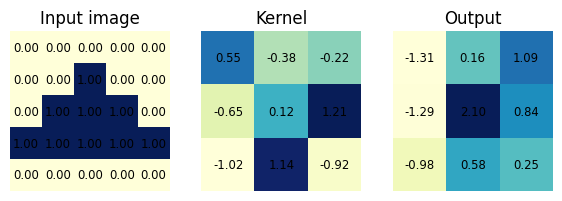

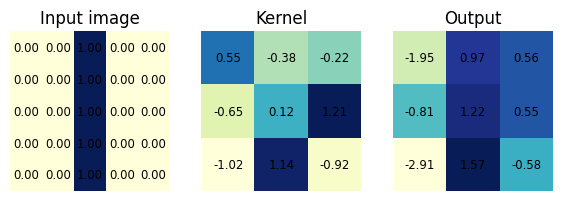

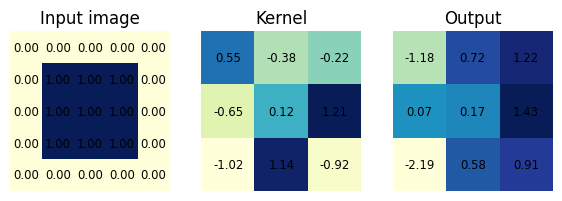

Epoch 280, error: 0.04552913719358433
Predicted: 0, actual: 0
Predicted: 1, actual: 1
Predicted: 2, actual: 2


In [25]:
network = [
    Convolutional((1, 5, 5), 3, 5),
    Sigmoid(),
    Reshape((5, 3, 3), (5 * 3 * 3, 1)),
    Dense(5 * 3 * 3, 100),
    Sigmoid(),
    Dense(100, 3),
    Softmax()
]

for epoch in range(EPOCHS):
    error = 0
    for x, y in zip(x_train, y_train):
        # Forward pass
        output = x

        for layer in network:
            temp_output = output
            output = layer.forward(output)

            # Visualize how the kernel convolutes the input image
            if (epoch % VISUALIZE_INTERVAL == 0 and layer.__class__ == Convolutional):
                utils.display_images([(temp_output[0], "Input image"), (layer.kernels[0, 0], "Kernel"), (output[0], "Output")], figsize=(7, 7))

        
        # Calculate error
        error += cross_entropy(y, output)

        # Backward pass
        grad = cross_entropy_prime(y, output)
        
        for layer in reversed(network):
            grad = layer.backward(grad, LEARNING_RATE)
        
    error /= len(x_train)
    if (epoch % VISUALIZE_INTERVAL == 0):
        print(f"Epoch {epoch}, error: {error}")

for x, y in zip(x_test, y_test):
    output = x
    for layer in network:
        output = layer.forward(output)
    print(f"Predicted: {np.argmax(output)}, actual: {np.argmax(y)}")

# MNIST Problem

Example of how the same network can be used to solve the MNIST problem. In order to reduce the complexity and training time, the training data is reduced from 10 classes to 2, and we only train on 100 of the images. The training still takes quite long time due to the unoptimized implementations of e.g. convolve2D, etc.

In [26]:
from keras.datasets import mnist
from keras.utils import np_utils

2022-10-12 10:37:54.936783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
def preprocess_data(x, y, limit):
    zero_index = np.where(y == 0)[0][:limit]
    one_index = np.where(y == 1)[0][:limit]
    all_indices = np.hstack((zero_index, one_index))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    x = x.reshape(len(x), 1, 28, 28)
    x = x.astype('float32') / 255
    y = np_utils.to_categorical(y)
    y = y.reshape(len(y), 2, 1)
    return x, y

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, 100)
x_test, y_test = preprocess_data(x_test, y_test, 100)

In [28]:
network = [
    Convolutional((1, 28, 28), 3, 5),
    Sigmoid(),
    Reshape((5, 26, 26), (5 * 26 * 26, 1)),
    Dense(5 * 26 * 26, 100),
    Sigmoid(),
    Dense(100, 2),
    Sigmoid()
]

epochs = 10
learning_rate = 0.1

for epoch in range(epochs):
    error = 0
    for x, y in zip(x_train, y_train):
        # Forward pass
        output = x
        for layer in network:
            output = layer.forward(output)
        
        # Calculate error
        error += binary_cross_entropy(y, output)

        # Backward pass
        grad = binary_cross_entropy_prime(y, output)
        
        for layer in reversed(network):
            grad = layer.backward(grad, learning_rate)
    
    error /= len(x_train)
    print(f"Epoch {epoch}, error: {error}")

for x, y in zip(x_test, y_test):
    output = x
    for layer in network:
        output = layer.forward(output)
    print(f"Predicted: {np.argmax(output)}, actual: {np.argmax(y)}")

Epoch 0, error: 0.25640947902058714
Epoch 1, error: 0.11129334696691248
Epoch 2, error: 0.04359817458834792
Epoch 3, error: 0.03882403856625652
Epoch 4, error: 0.08032354536667792
Epoch 5, error: 0.0249856968330059
Epoch 6, error: 0.011027305009866145
Epoch 7, error: 0.008646321645915583
Epoch 8, error: 0.008610116855033191
Epoch 9, error: 0.00461263835089808
Predicted: 0, actual: 0
Predicted: 1, actual: 1
Predicted: 1, actual: 1
Predicted: 0, actual: 0
Predicted: 0, actual: 0
Predicted: 1, actual: 1
Predicted: 1, actual: 1
Predicted: 0, actual: 0
Predicted: 0, actual: 0
Predicted: 1, actual: 1
Predicted: 1, actual: 1
Predicted: 1, actual: 1
Predicted: 0, actual: 0
Predicted: 0, actual: 0
Predicted: 1, actual: 1
Predicted: 1, actual: 1
Predicted: 0, actual: 0
Predicted: 0, actual: 0
Predicted: 1, actual: 1
Predicted: 1, actual: 1
Predicted: 0, actual: 0
Predicted: 1, actual: 1
Predicted: 1, actual: 1
Predicted: 1, actual: 1
Predicted: 0, actual: 0
Predicted: 1, actual: 1
Predicted: 0, 